In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") 
import time 
import random 
import pymc3 as pm
import arviz as az 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.preprocessing import StandardScaler 
from sklearn.gaussian_process.kernels import DotProduct as lin, WhiteKernel, RBF, ConstantKernel as C, RationalQuadratic as RQ, ExpSineSquared as Exp  
import matplotlib.pyplot as plt

#from spring_damp import spring_damp_mass

ss = StandardScaler()

df = pd.read_csv('sim_1.csv') 

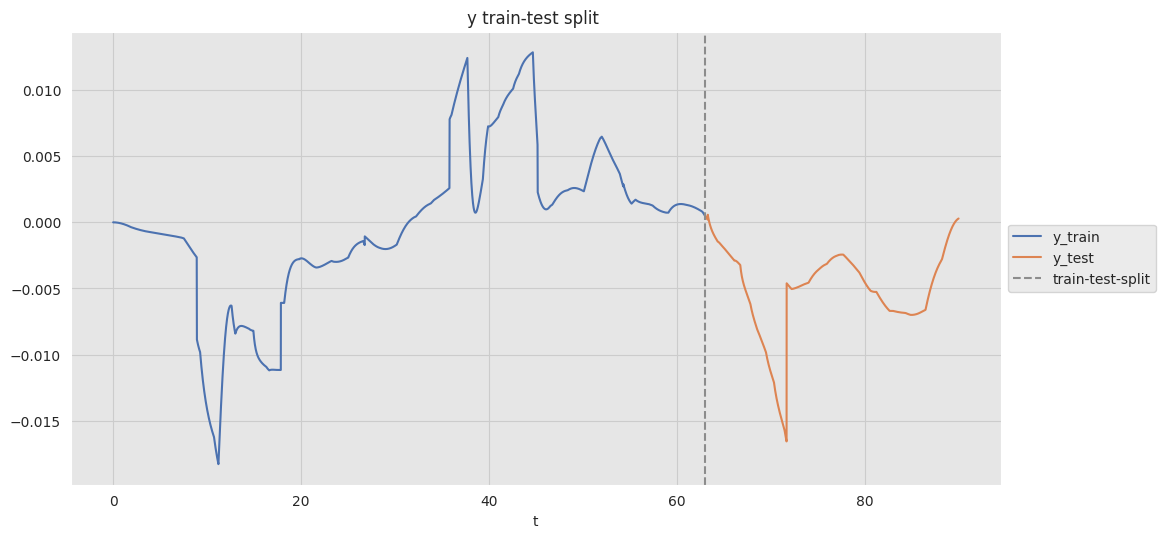

In [4]:
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

n = 9001 

x = df['time_step'].values.reshape(n, 1)
y = df['G(x)'].values.reshape(n,1)

prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');


In [5]:
with pm.Model() as model:

    # First seasonal component.
    ls_1 = pm.Gamma(name='ls_1', alpha=2.0, beta=1.0)
    period_1 = pm.Gamma(name='period_1', alpha=80, beta=2)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))
    # Second seasonal component.
    ls_2 = pm.Gamma(name='ls_2', alpha=2.0, beta=1.0)
    period_2 = pm.Gamma(name='period_2', alpha=30, beta=2)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))
    # Linear trend.
    c_3 = pm.Normal(name='c_3', mu=1, sigma=2)
    gp_3 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c_3))
    # Define gaussian process.
    gp = gp_1 + gp_2 + gp_3
    # Noise.
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    # Likelihood.
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train.flatten(), noise=sigma)
    # Sample.
    trace = pm.sample(draws=2000, chains=3, tune=500)